## Data Story
### Instacart Market Basket Analysis EDA: Customer Engagement
----
Ryan Alexander Alberts

6/26/2017

#### In this notebook, I want to explore how customer engagement affects reorder behavior. 

 __Introductory Comments:__
 
The more a customer engages with an eCommerce grocer like Instacart, the more likely Instacart will become authoritative and trustworthy in the eyes of that customer, and the more likely the customer will become familiar with the quality of products they unpack from Instacart boxes. 

Bridging the gap between digital storefronts and traditional brick-and-morter stores continues to be a critical obstacle for customer acquisiton and engagemenet in eCommerce. Uncertainties about the supply-chain and product quality can detract from the shopping experience in meaningful, irrevocable ways.

Fundamentally, the more orders a customer places, the less likely they will confront questions that traditionally plague eCommerce grocers: 'How fast will it get here?', 'Can I trust this website?', 'How fresh is this?', and the more likely they will be to trust the website, order more frequently, etc.


---- 

We are capable of measuring engagement in a number of ways with this dataset.

* ** Total number of orders per customer    --> Reorder behavior**
* ** 'New' vs. 'Seasoned' customers         --> Reorder behavior**


Areas of Interest:

* Does a larger number of distinct orders correlate with some reorder behavior (reorder rate, reordered items as a percentage of basket size, etc)? 

----

Hypothesis:
More experienced customers (larger number of distinct orders) will tend to have the following behavior:

* More products per order
* Orders containing less experimental products (products never ordered before)
* More frequent orders
* Higher tolerance for ordering at odd hours


In [298]:
import pandas as pd
import re
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")

In [293]:
# First, let's import requisite files
orders = pd.read_csv('../Instacart_Input/orders.csv')
prior_set = pd.read_csv('../Instacart_Input/order_products__prior.csv')
train_set = pd.read_csv('../Instacart_Input/order_products__train.csv')
products    = pd.read_csv('../Instacart_Input/products.csv')

In [39]:
orders.head(15)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [40]:
# Totals by Eval_Set
orders['eval_set'].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

In [41]:
print '\nTotal Unique Orders:    ' + str(len(np.unique(orders['order_id'])))
print 'Total Unique Customers:  ' + str(len(np.unique(orders['user_id'])))


Total Unique Orders:    3421083
Total Unique Customers:  206209


In [42]:
# Range of unique orders per customer confirmed: 4 - 100
orders['user_id'].value_counts().head(), orders['user_id'].value_counts().tail()

(53684     100
 201623    100
 50817     100
 176951    100
 88911     100
 Name: user_id, dtype: int64, 24224     4
 199509    4
 32420     4
 21310     4
 196830    4
 Name: user_id, dtype: int64)

In [300]:
# Total Number of orders for each user_id

Customer_order_counts = orders.loc[:,('user_id', 
                                      'eval_set')].groupby('user_id').size().reset_index()

Customer_order_counts = Customer_order_counts.rename(columns=
                                                     {'user_id' : 'user_id', 
                                                      0 : "order_count"
                                                     })
Customer_order_counts.head()

,user_id,order_count
0,1,11
1,2,15
2,3,13
3,4,6
4,5,5


In [237]:
v = Customer_order_counts[Customer_order_counts['order_count'] > 3]['user_id'].count()
x = Customer_order_counts[Customer_order_counts['order_count'] > 5]['user_id'].count()
y = Customer_order_counts[Customer_order_counts['order_count'] > 7]['user_id'].count()
z = Customer_order_counts[Customer_order_counts['order_count'] > 10]['user_id'].count()

print '%d Customers had %d or more orders,\
        \naccounting for approx. %d percent of total\n' % (x, 5, round((x / float(v) * 100), 2))
print '%d Customers had %d or more orders,\
        \naccounting for approx. %d percent of total\n' % (y, 7, round((y / float(v) * 100), 2))
print '%d Customers had %d or more orders,\
        \naccounting for approx. %d percent of total\n' % (z, 10, round((z / float(v) * 100), 2))

162633 Customers had 5 or more orders,        
accounting for approx. 78 percent of total

132618 Customers had 7 or more orders,        
accounting for approx. 64 percent of total

101696 Customers had 10 or more orders,        
accounting for approx. 49 percent of total



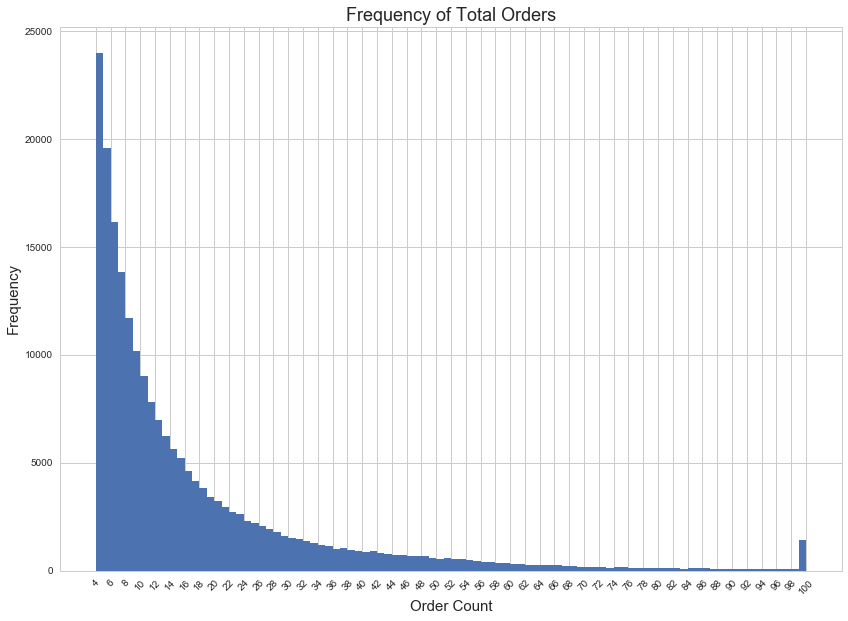

In [44]:
# Plotting distribution of customer order frequency. 

f, ax = plt.subplots(figsize=(14,10))
plt.hist(Customer_order_counts['order_count'], bins=np.arange(4,101))
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Order Count', fontsize=15)
plt.xticks(np.arange(4,101,2), rotation=45)
plt.title("Frequency of Total Orders", fontsize=18);

In [303]:
# Let's take a look at reorder rates for different customer segments.

# First, let's segment 'new' vs. 'seasoned' customers, by focusing on six order_number sets

segments = {}

# 'new' customers
segments['orders_02_03_new']            = orders[
                                                 (orders['order_number'] < 4) 
                                                 & (orders['order_number'] > 1)
                                                ].sort_values('user_id')
# 'intermediate' customers
segments['orders_07_08_intermediate']   = orders[
                                                 (orders['order_number'] < 8) 
                                                  & (orders['order_number'] > 5)
                                                ].sort_values('user_id')
# 'almost-seasoned' customers
segments['orders_10_11_almostseasoned'] = orders[
                                                 (orders['order_number'] < 12) 
                                                  & (orders['order_number'] > 9)
                                                ].sort_values('user_id')
# 'seasoned' customers
segments['orders_20_21_seasoned']       = orders[
                                                 (orders['order_number'] < 22) 
                                                  & (orders['order_number'] > 19)
                                                ].sort_values('user_id')
# 'pro' customers
segments['orders_40_41_pro']            = orders[
                                                 (orders['order_number'] < 42) 
                                                  & (orders['order_number'] > 39)
                                                ].sort_values('user_id')
# 'super-pro' customers
segments['orders_80_81_superpro']       = orders[
                                                 (orders['order_number'] < 82) 
                                                  & (orders['order_number'] > 79)
                                                ].sort_values('user_id')



# Let's merge order assortment data into prior order data
for segment in segments:
    segments[segment] = segments[segment].merge(prior_set, on='order_id')
    
segments['orders_02_03_new'].head(15)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2398795,1,prior,2,3,7,15.0,196,1,1
1,2398795,1,prior,2,3,7,15.0,10258,2,0
2,2398795,1,prior,2,3,7,15.0,12427,3,1
3,2398795,1,prior,2,3,7,15.0,13176,4,0
4,2398795,1,prior,2,3,7,15.0,26088,5,1
5,2398795,1,prior,2,3,7,15.0,13032,6,0
6,473747,1,prior,3,3,12,21.0,196,1,1
7,473747,1,prior,3,3,12,21.0,12427,2,1
8,473747,1,prior,3,3,12,21.0,10258,3,1
9,473747,1,prior,3,3,12,21.0,25133,4,0


In [304]:
reordered     = segments['orders_02_03_new']['reordered'].value_counts()[1]
not_reordered = segments['orders_02_03_new']['reordered'].value_counts()[0]
pct_reordered = str(round(reordered / float(reordered + not_reordered)*100, 2)) + '%'
print 'Instances of Reordered Items:      ' + str(segments['orders_02_03_new'].reordered.sum())
print 'Total Number of Items Purchased:   ' + str(segments['orders_02_03_new'].shape[0])
print '\nOrders 2 & 3: Unique instances of a previously ordered product being ordered:' + '\nReorder Rate: ' + pct_reordered 

Instances of Reordered Items:      1350046
Total Number of Items Purchased:   4099063

Orders 2 & 3: Unique instances of a previously ordered product being ordered:
Reorder Rate: 32.94%


----
As expected, the reorder rate of **32.94% for orders 2 & 3** is significantly lower than the **overall reorder rate of 58.97%**

----

In [192]:
# Let's compare against the other segments

pct_list = []
for segment in segments:
    reordered         = segments[segment]['reordered'].value_counts()[1]
    not_reordered     = segments[segment]['reordered'].value_counts()[0]
    pct_reordered     = str(round(reordered / float(reordered + not_reordered)*100, 2)) + '%'
    pct_list.append(round(reordered / float(reordered + not_reordered)*100, 2))

pct_name = []
for f in segments.keys():
    pct_name.append(f)
pct_list.sort()
pct_name.sort()
i = 0

for f in pct_list:
    print str(pct_name[i]), '\nUnique instances of a previously ordered product being ordered:\
                            ' + '\nReorder Rate: ' + str(f) + '%\n' 
    i+=1

orders_02_03_new 
Unique instances of a previously ordered product being ordered:                            
Reorder Rate: 32.94%

orders_07_08_intermediate 
Unique instances of a previously ordered product being ordered:                            
Reorder Rate: 55.97%

orders_10_11_almostseasoned 
Unique instances of a previously ordered product being ordered:                            
Reorder Rate: 64.41%

orders_20_21_seasoned 
Unique instances of a previously ordered product being ordered:                            
Reorder Rate: 73.97%

orders_40_41_pro 
Unique instances of a previously ordered product being ordered:                            
Reorder Rate: 80.27%

orders_80_81_superpro 
Unique instances of a previously ordered product being ordered:                            
Reorder Rate: 83.94%



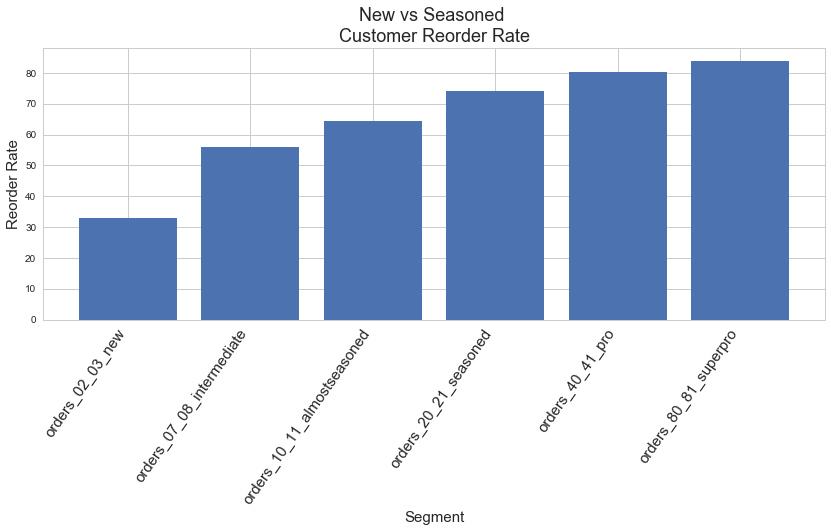

In [190]:
#Let's visualize the differences
f, ax = plt.subplots(figsize=(14,5))

ax.bar(range(6), pct_list)
plt.ylabel('Reorder Rate', fontsize=15)
plt.xlabel('Segment', fontsize=15)
plt.xticks(range(6), pct_name, ha='right', rotation=55, fontsize=15)
plt.title("New vs Seasoned \nCustomer Reorder Rate", fontsize=18);

----
### Now let's look at the distribution of Product Count per Order
----

In [267]:
# Plotting distribution of product counts for different segments. 
first_orders    = segments['orders_02_03_new']['order_id'].value_counts()
intermediate    = segments['orders_07_08_intermediate']['order_id'].value_counts()
almost_seasoned = segments['orders_10_11_almostseasoned']['order_id'].value_counts()
seasoned        = segments['orders_20_21_seasoned']['order_id'].value_counts()
pro             = segments['orders_40_41_pro']['order_id'].value_counts()
superpro        = segments['orders_80_81_superpro']['order_id'].value_counts()

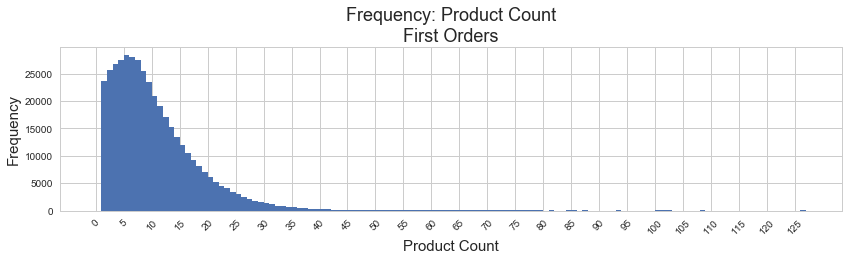

In [285]:
# Let's plot product count distribution for 'new' customers

f, ax = plt.subplots(figsize=(14,3))
plt.hist(first_orders, bins=np.arange(128))
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Product Count', fontsize=15)
plt.xticks(np.arange(0,130,5), rotation=45)
plt.title("Frequency: Product Count\nFirst Orders", fontsize=18);

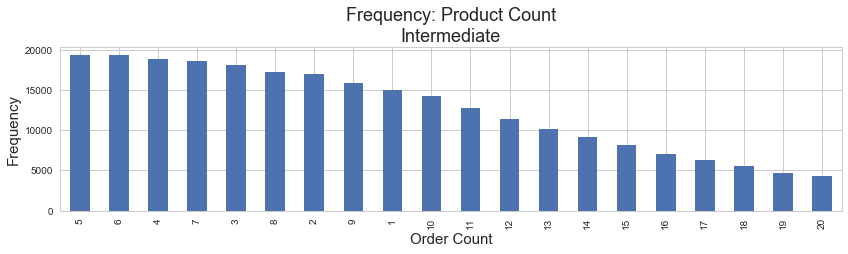

In [286]:
plt.figure(figsize=(14,3))
intermediate.value_counts()[:20].plot(kind='bar')
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Order Count', fontsize=15)
plt.title("Frequency: Product Count\nIntermediate", fontsize=18);

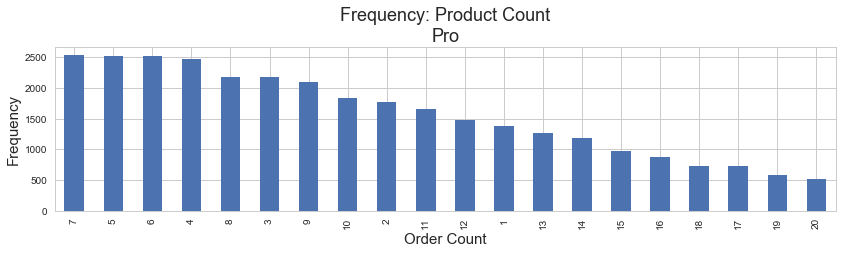

In [287]:
plt.figure(figsize=(14,3))
pro.value_counts()[:20].plot(kind='bar')
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Order Count', fontsize=15)
plt.title("Frequency: Product Count\nPro", fontsize=18);


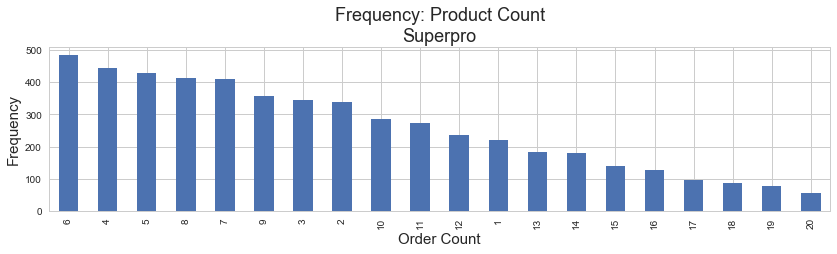

In [288]:
# Let's plot the top 20 for a closer look
plt.figure(figsize=(14,3))
superpro.value_counts()[:20].plot(kind='bar')
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Order Count', fontsize=15)
plt.title("Frequency: Product Count\nSuperpro", fontsize=18);

#### Of Note:
* There's actually a remarkable consistency from order_number 2 to order_number 3

In [305]:
# Customer Order Count, segmented by eval_set

order_count_bySet = orders.loc[:,('user_id', 'eval_set')].groupby(['user_id', 'eval_set']).size()
order_count_bySet.unstack().fillna('--')[:20]

eval_set,prior,test,train
user_id,,,
1,10.0,--,1
2,14.0,--,1
3,12.0,1,--
4,5.0,1,--
5,4.0,--,1
6,3.0,1,--
7,20.0,--,1
8,3.0,--,1
9,3.0,--,1


----
### Let's do a quick dive into User_id 1:
----


In [297]:
# List of their orders in proir set
user_1_orders = orders[orders['user_id'] == 1]['order_id']

# merge order details (i.e. order_id | product_id)
user_1 = prior_set[prior_set['order_id'].isin(user_1_orders.values)]
user_1 = user_1.merge(orders, on='order_id')
user_1 = user_1.merge(products, on='product_id')
user_1.sort_values(by=['order_number', 'add_to_cart_order'])[:20]

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
6,2539329,196,1,0,1,prior,1,2,8,NaN,Soda,77,7
55,2539329,14084,2,0,1,prior,1,2,8,NaN,Organic Unsweetened Vanilla Almond Milk,91,16
16,2539329,12427,3,0,1,prior,1,2,8,NaN,Original Beef Jerky,23,19
54,2539329,26088,4,0,1,prior,1,2,8,NaN,Aged White Cheddar Popcorn,23,19
47,2539329,26405,5,0,1,prior,1,2,8,NaN,XL Pick-A-Size Paper Towel Rolls,54,17
5,2398795,196,1,1,1,prior,2,3,7,15.0,Soda,77,7
25,2398795,10258,2,0,1,prior,2,3,7,15.0,Pistachios,117,19
15,2398795,12427,3,1,1,prior,2,3,7,15.0,Original Beef Jerky,23,19
41,2398795,13176,4,0,1,prior,2,3,7,15.0,Bag of Organic Bananas,24,4
53,2398795,26088,5,1,1,prior,2,3,7,15.0,Aged White Cheddar Popcorn,23,19


In [295]:
# Complete list of previously purchased products by user_id 1
np.unique(user_1['product_id'])

# Order Frequency by product_id 
User1_product_count = user_1.groupby('product_name').size()
User1_product_count.sort_values(ascending=False)

product_name
Soda                                       10
Original Beef Jerky                        10
Pistachios                                  9
Organic String Cheese                       8
Zero Calorie Cola                           3
Cinnamon Toast Crunch                       3
Aged White Cheddar Popcorn                  2
Bag of Organic Bananas                      2
Organic Half & Half                         2
XL Pick-A-Size Paper Towel Rolls            2
Creamy Almond Butter                        1
Bartlett Pears                              1
Organic Fuji Apples                         1
Honeycrisp Apples                           1
Milk Chocolate Almonds                      1
Organic Unsweetened Almond Milk             1
Organic Unsweetened Vanilla Almond Milk     1
0% Greek Strained Yogurt                    1
dtype: int64

In [296]:
train_set[train_set['order_id'] == 1187899].merge(products, on='product_id')


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,1187899,196,1,1,Soda,77,7
1,1187899,25133,2,1,Organic String Cheese,21,16
2,1187899,38928,3,1,0% Greek Strained Yogurt,120,16
3,1187899,26405,4,1,XL Pick-A-Size Paper Towel Rolls,54,17
4,1187899,39657,5,1,Milk Chocolate Almonds,45,19
5,1187899,10258,6,1,Pistachios,117,19
6,1187899,13032,7,1,Cinnamon Toast Crunch,121,14
7,1187899,26088,8,1,Aged White Cheddar Popcorn,23,19
8,1187899,27845,9,0,Organic Whole Milk,84,16
9,1187899,49235,10,1,Organic Half & Half,53,16


In [59]:
# Only product_id 27845 is irrelevant for competition, 
# because it had never been ordered before.
# All other products had been ordered 
# (in 1 of the 10 previous orders before order_number 11 (training))
# and must thus be among those ranked by 
# predictive algorithm for inclusion in submission file. 

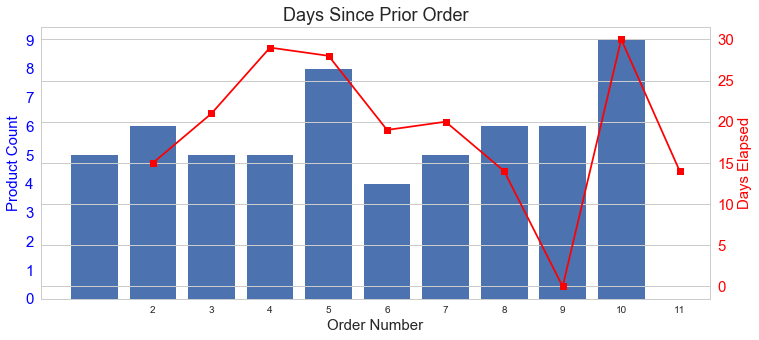

In [60]:
# Plot days since prior order against product count

data = orders[orders['user_id']==1].sort_values(by='order_number')[['order_number', 'days_since_prior_order']]
data = data.set_index('order_number')
data2 = user_1['order_number'].value_counts()

plt.figure(figsize=(12,5))
plt.title("Days Since Prior Order", fontsize=18)
plt.ylabel('Product Count', fontsize=15, color='b')
plt.yticks(range(10), color='b', fontsize=15)
plt.xlabel('Order Number', fontsize=15)
plt.bar(data2.index, data2.values);
plt.grid(b=False)


ax2 = plt.twinx()
plt.plot(data, 'rs-')
plt.ylabel('Days Elapsed', color='r', fontsize=15)
plt.xticks(range(2,12))
plt.yticks(range(0,32,5), color='r', fontsize=15);


#### Of Note:
1. cyclicality 
2. correlation between product_id count (bars) and days since prior order (line)


In [61]:
data2.sort_index() # order_number and corresponding products count

1     5
2     6
3     5
4     5
5     8
6     4
7     5
8     6
9     6
10    9
Name: order_number, dtype: int64